# Package loading and basic configurations

In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import matplotlib.pyplot as plt
import scipy
from scipy.misc import derivative
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from envirocar import TrackAPI, DownloadClient, BboxSelector, TimeSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Münster (Germany) and requests 50 tracks in the time interval. 

In [2]:
bbox = BboxSelector([
    7.603312, # min_x
    51.952343, # min_y
    7.65083, # max_x 
    51.974045,  # max_y 
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox,  num_results=50) # requesting 50 tracks inside the bbox



In [3]:
one_track_id = track_df['track.id'].unique()[2]
one_track = track_df[track_df['track.id'] == one_track_id]
one_track

,id,time,geometry,Speed.value,Speed.unit,Throttle Position.value,Throttle Position.unit,GPS VDOP.value,GPS VDOP.unit,GPS Altitude.value,...,sensor.constructionYear,sensor.manufacturer,track.appVersion,track.touVersion,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,MAF.value,MAF.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit
0,5eec7aacd6e3cf256ba3f8bf,2020-06-14T16:39:02,POINT (7.65130 51.95398),15.368055,km/h,16.000000,%,1.000000,precision,107.577199,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5eec7aacd6e3cf256ba3f8c1,2020-06-14T16:39:07,POINT (7.65094 51.95400),12.721154,km/h,16.000000,%,1.000000,precision,105.000000,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5eec7aacd6e3cf256ba3f8c2,2020-06-14T16:39:12,POINT (7.65080 51.95405),9.000000,km/h,16.748776,%,1.000000,precision,103.396414,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5eec7aacd6e3cf256ba3f8c3,2020-06-14T16:39:17,POINT (7.65083 51.95419),19.187311,km/h,18.197452,%,1.636784,precision,101.601326,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5eec7aacd6e3cf256ba3f8c4,2020-06-14T16:39:22,POINT (7.65087 51.95445),21.865270,km/h,15.000000,%,1.339819,precision,104.391566,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,5eec7aacd6e3cf256ba3fab1,2020-06-14T17:20:50,POINT (7.70877 52.26030),21.945558,km/h,15.000000,%,0.886405,precision,119.000000,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,5eec7aacd6e3cf256ba3fab2,2020-06-14T17:20:55,POINT (7.70847 52.26029),8.822055,km/h,15.000000,%,0.800000,precision,119.000004,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499,5eec7aacd6e3cf256ba3fab3,2020-06-14T17:21:00,POINT (7.70849 52.26021),6.089674,km/h,15.000000,%,0.870858,precision,119.000004,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500,5eec7aacd6e3cf256ba3fab4,2020-06-14T17:21:05,POINT (7.70853 52.26020),0.000000,km/h,15.000000,%,0.800000,precision,119.000004,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Retrieve the Location of the Route

The latitude and longitude of the track with the stops from the one_track.

In [4]:
a=one_track['geometry']  #conveys location info about the route 
print(a)

0      POINT (7.65130 51.95398)
1      POINT (7.65094 51.95400)
2      POINT (7.65080 51.95405)
3      POINT (7.65083 51.95419)
4      POINT (7.65087 51.95445)
                 ...           
497    POINT (7.70877 52.26030)
498    POINT (7.70847 52.26029)
499    POINT (7.70849 52.26021)
500    POINT (7.70853 52.26020)
501    POINT (7.70853 52.26020)
Name: geometry, Length: 502, dtype: geometry


Plot the route from the coordinates that can be changed as per the requirements.

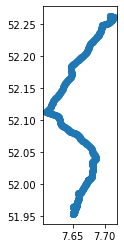

In [5]:
a.plot() #plotting the route 

The route of the track in the interactive map for the easier understanding and better visualization.

In [8]:
import folium
lats = list(one_track['geometry'].apply(lambda coord: coord.y))
lngs = list(one_track['geometry'].apply(lambda coord: coord.x))
avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)
m = folium.Map(location=[avg_lat, avg_lngs], zoom_start=13)
folium.PolyLine([coords for coords in zip(lats, lngs)], color='blue').add_to(m)
m 
#plotting the route in the map for reference

# Elevation profile of the route

The Elevation profile of the selected route is defined with the start and the end coordinates of the route.

In [9]:
import urllib.request
import json
import math
import matplotlib.pyplot as plt

#defining start end points of the route
P1=[51.95398,7.65130]  
P2=[52.26020,7.70853]  

#To define the number of points
s=100
interval_lat=(P2[0]-P1[0])/s #interval for latitude
interval_lon=(P2[1]-P1[1])/s #interval for longitude

 
lat0=P1[0]
lon0=P1[1]

#Defining latitude and longitude list
lat_list=[lat0]
lon_list=[lon0]

 
for i in range(s):
    lat_step=lat0+interval_lat
    lon_step=lon0+interval_lon
    lon0=lon_step
    lat0=lat_step
    lat_list.append(lat_step)
    lon_list.append(lon_step)

#haversine function to calculate the distance between the route.
def haversine(lat1,lon1,lat2,lon2):
    lat1_rad=np.radians(lat1)
    lat2_rad=np.radians(lat2)
    lon1_rad=np.radians(lon1)
    lon2_rad=np.radians(lon2)
    delta_lat=lat2_rad-lat1_rad
    delta_lon=lon2_rad-lon1_rad
    a=np.sqrt((np.sin(delta_lat/2))**2+np.cos(lat1_rad)*np.cos(lat2_rad)*(np.sin(delta_lon/2))**2)
    d=2*6371000*np.arcsin(a)
    return d   
     

# constructing json to retreive the elevation from the API

In [10]:
 
d_list=[]
for j in range(len(lat_list)):
    lat_p=lat_list[j]
    lon_p=lon_list[j]
    dp=haversine(lat0,lon0,lat_p,lon_p)/1000 #km
    d_list.append(dp)
d_list_rev=d_list[::-1] #reverse list


#
d_ar=[{}]*len(lat_list)
for i in range(len(lat_list)):
    d_ar[i]={"latitude":lat_list[i],"longitude":lon_list[i]}
location={"locations":d_ar}
json_data=json.dumps(location,skipkeys=int).encode('utf8')
print(json_data)
import requests as req

url = 'https://api.opentopodata.org/v1/eudem25m?locations='   #retrieve elevation data from opentopodata.org
def get_elvdata(lat,lng):
    access = url+str(lat)+(',')+str(lng)
    elevation = req.request('GET',access)
    data = eval(elevation.text)
    print(data)
    return data['results'][0]['elevation']
elev_list= []

#Time function to retreive 1 elevation data in 1 second for all the points.

import time

    
try:
    for i in range(len(lat_list)):
        elev_list.append(get_elvdata(lat_list[i],lon_list[i]))       
        time.sleep(1)
except Exception as err:
    print(str(err))
#giving 1 second time to retrieve data from server for all the elevation data    
print(elev_list)

    

b'{"locations": [{"latitude": 51.95398, "longitude": 7.6513}, {"latitude": 51.957042200000004, "longitude": 7.6518723}, {"latitude": 51.960104400000006, "longitude": 7.6524446}, {"latitude": 51.96316660000001, "longitude": 7.6530169}, {"latitude": 51.96622880000001, "longitude": 7.6535892}, {"latitude": 51.96929100000001, "longitude": 7.6541615}, {"latitude": 51.972353200000015, "longitude": 7.6547338}, {"latitude": 51.97541540000002, "longitude": 7.6553061}, {"latitude": 51.97847760000002, "longitude": 7.6558784}, {"latitude": 51.98153980000002, "longitude": 7.6564507}, {"latitude": 51.984602000000024, "longitude": 7.657023}, {"latitude": 51.987664200000026, "longitude": 7.6575953}, {"latitude": 51.99072640000003, "longitude": 7.6581676}, {"latitude": 51.99378860000003, "longitude": 7.6587399}, {"latitude": 51.99685080000003, "longitude": 7.6593122}, {"latitude": 51.999913000000035, "longitude": 7.6598844999999995}, {"latitude": 52.00297520000004, "longitude": 7.6604567999999995}, {"l

# basic statistics information for defining the maximum,minimum and the average elevation value.

In [11]:

mean_elev=round((sum(elev_list)/len(elev_list)),3)
min_elev=min(elev_list)
max_elev=max(elev_list)
distance=d_list_rev[-1] 

# plot elevation profile with min, max and average elevation from the above calculations for the given route.

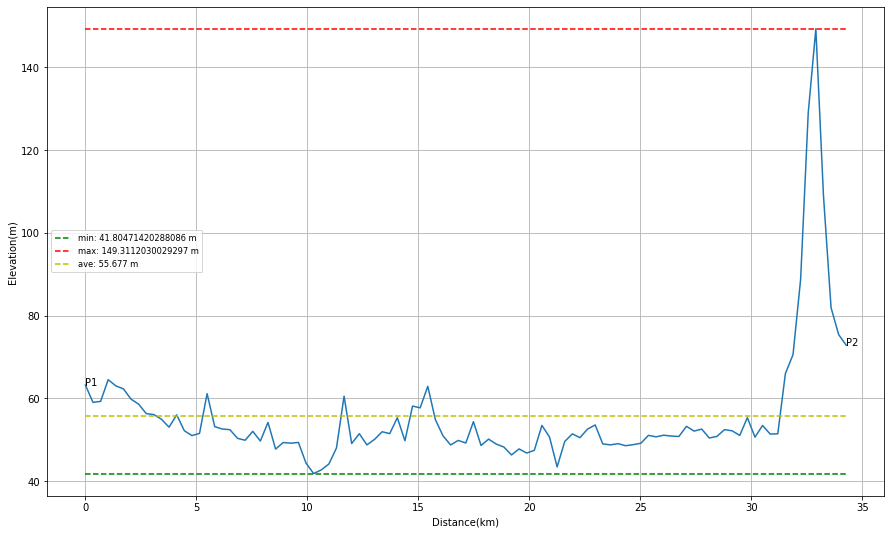

In [12]:

base_reg=0
plt.figure(figsize=(15,9))
plt.plot(d_list_rev,elev_list)
plt.plot([0,distance],[min_elev,min_elev],'--g',label='min: '+str(min_elev)+' m')
plt.plot([0,distance],[max_elev,max_elev],'--r',label='max: '+str(max_elev)+' m')
plt.plot([0,distance],[mean_elev,mean_elev],'--y',label='ave: '+str(mean_elev)+' m')
plt.text(d_list_rev[0],elev_list[0],"P1")
plt.text(d_list_rev[-1],elev_list[-1],"P2")
plt.xlabel("Distance(km)")
plt.ylabel("Elevation(m)")
plt.grid()
plt.legend(fontsize='small')
plt.show()